Only working on Bruno's machine because of file paths.

To run it on an other computer, you'll need to change the pickle file's path if you doesn't have the same relative path.

In [1]:
# Pose Estimation in Paintings
# the point of this section is to read in a big paintings dataset (the web gallery) and provide poses per image. 
# (note to self. Try training on paintings after photos and then TESTING BACK ON PHOTOS. 
# If we've learned something generalisable, it should increase our performance there too!)

In [2]:
import numpy as np
import scipy
import scipy.spatial
import PIL.Image
import math
import time
#from config_reader import config_reader
#import util
import copy
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import cv2 as cv 
import scipy
from scipy.ndimage.filters import gaussian_filter
import pickle
import wget

from PIL import Image
import requests
from StringIO import StringIO


import csv
import re
import tqdm
import body as bd

import bqplot as bqp
from ipywidgets import interact

In [3]:
myPaintings = pickle.load(open('../../Python Scripts/myPaintings07500.p', 'rb'))


## HERE go buc corrections to the catalog, which are numerous.... 
myPaintings[7465][1] = 'http://www.wga.hu/art/c/casa/portrait_C.jpg' ## and NOT portrait_c (lowercase), the original...



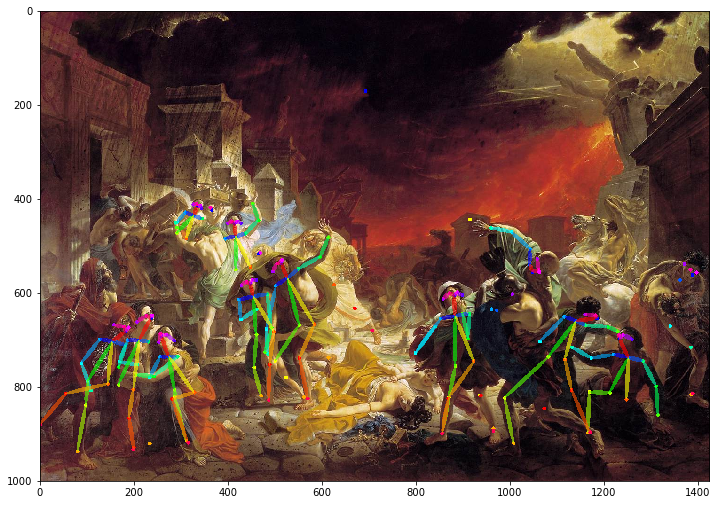

In [4]:
# Bruno has only files 000033 and 006251
vis_index = 6251
image_name = myPaintings[vis_index][0]
subset     = myPaintings[vis_index][2]
candidate  = myPaintings[vis_index][3]
all_peaks  = myPaintings[vis_index][4]


colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]
cmap = matplotlib.cm.get_cmap('hsv')

oriImg = cv.imread(image_name) # B,G,R order
canvas = cv.imread(image_name) # B,G,R order


for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
# plt.imshow(to_plot[:,:,[2,1,0]])
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(12, 12)

# visualize 2
stickwidth = 4


for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
     
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

for i in range(20):
    print(points[i])
    
for n in range(len(subset)):
    for i in range(len(links[n])):
        print(links[n][i])

In [5]:
# len(subset) is the number of people. 
# First test: print the number of people in portrait vs mythological vs landscape vs religious painting.

subPaintings = myPaintings[1:16300]
print(subPaintings[3][13])
port_n = 0
port_p = 0
myth_n = 0
myth_p = 0
land_n = 0
land_p = 0
relg_n = 0
relg_p = 0

for s in subPaintings:
    if s[12] == 'painting' and s[13] == 'portrait':
        port_n += 1
        port_p += len(s[2])
    
print(1.0*port_p/port_n)    
int(s[15][:4])

portrait
4.32337317397


1851

In [6]:
#6 seconds in my computer
all_bodies = bd.construct_body_list(7500, myPaintings)

In [7]:
all_relative_angles = bd.get_all_relative_angles(all_bodies)

In [8]:
#2 seconds in my computer
#We can multiply the mean lengths by 2 to be more precise and have better views
ll = bd.all_bodies_mean_limb_length(all_bodies) * np.array(2.)

In [9]:
resized_bodies = bd.resize_all_bodies(all_bodies, (500,300), ll)

19.847834759243337

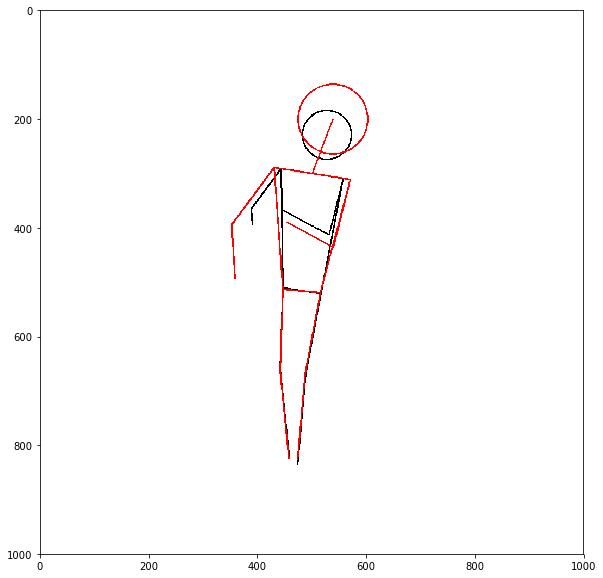

In [10]:
body_id = 127
black = (0,0,0)
red = (1,0,0)
width, height = 1000, 1000
skeletons_img = np.ones((height, width, 3))

body = resized_bodies[body_id]
limbs = body[1]

#draw the skeleton
skeletons = bd.points_to_skeleton(body, black, skeletons_img)

#find skeleton with mean limbs lengths
angles = bd.find_absolute_angles(body)
body_bis = bd.angles_to_body(angles,limbs,ll,(500,300), body[2])

#draw this second skeleton in red
skeletons_img = bd.points_to_skeleton(body_bis, red, skeletons_img)
plt.imshow(skeletons_img)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 10)

#compute the error between the two skeletons
ignored = bd.find_ignored_points(body_bis[0])
bd.mean_error_between_bodies(body, body_bis)

In [11]:
base_body = bd.angles_to_body(bd.base_angles(),bd.base_limbs(),ll,(500,300), bd.base_ignored())
bd.interactive_skeleton(base_body, all_relative_angles, resized_bodies)

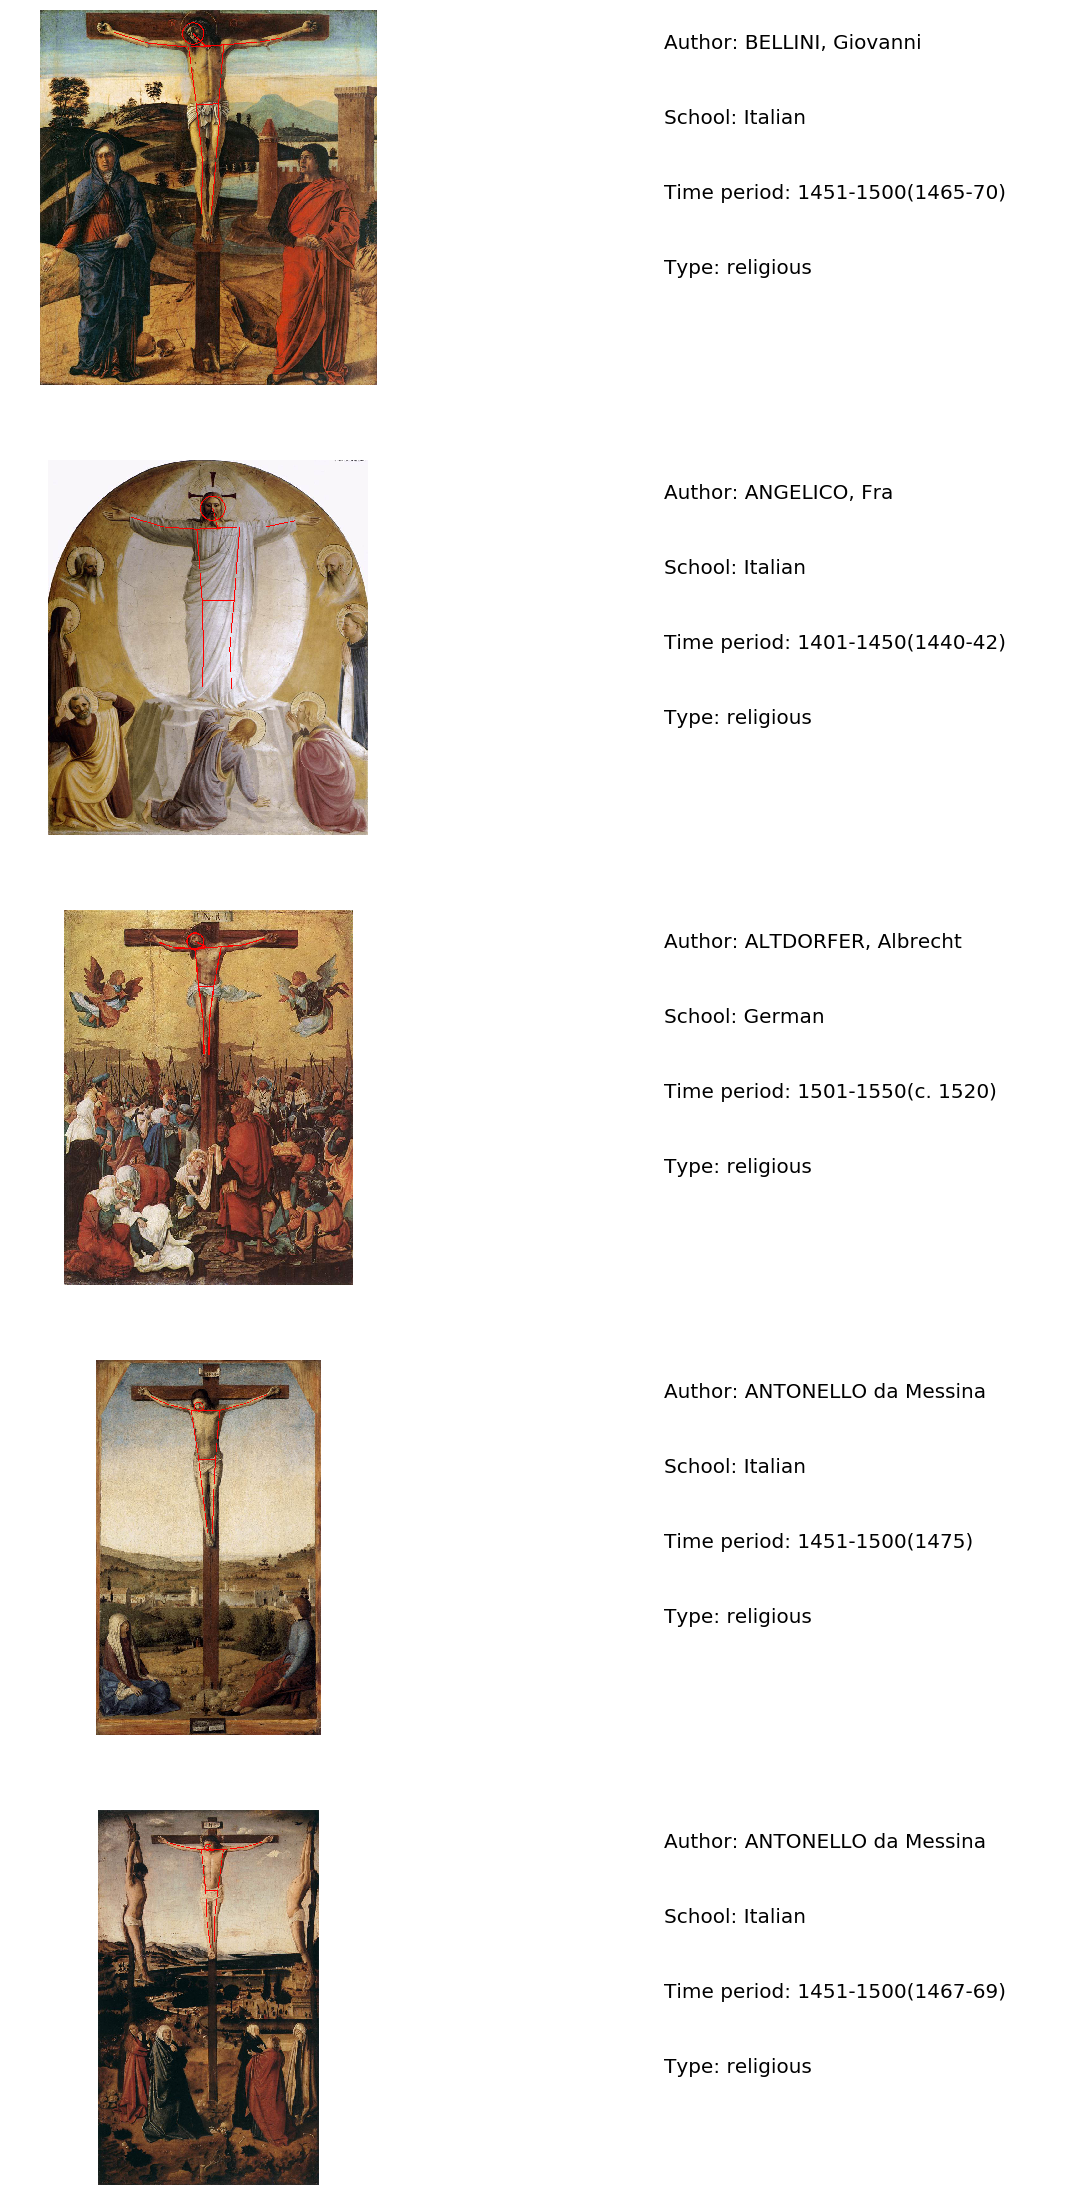

In [54]:
def plot_n_nearest_neighbors(angles, body, bodies, paintings, n):
    """plot the n nearest neighbor's paintings with skeleton drawn on them with some info on the painting"""
    bd_i = bd.get_n_nearest_neighbor(all_relative_angles, base_body, n)
    f, ax = plt.subplots(n,2, figsize=(20,40))
    for i in range(n):
        p_id = bodies[bd_i[i]][3]
        response = requests.get(myPaintings[p_id][1])
        img = np.array(Image.open(StringIO(response.content)))
        img = bd.points_to_skeleton(all_bodies[bd_i[i]], (255, 0, 0), img)
        ax[i, 0].imshow(img)
        ax[i, 1].text(0.2,0.5,'Time period: ' + str(myPaintings[p_id][15]) + '(' +  str(myPaintings[p_id][8]) + ')', fontsize = 20)
        ax[i, 1].text(0.2,0.3,'Type: ' + str(myPaintings[p_id][13]), fontsize = 20)
        ax[i, 1].text(0.2,0.7,'School: ' + str(myPaintings[p_id][14]), fontsize = 20)
        ax[i, 1].text(0.2,0.9,'Author: ' + str(myPaintings[p_id][5]), fontsize = 20)
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
    
    plt.show()
    f.set_size_inches(10, 10)
    

plot_n_nearest_neighbors(all_relative_angles, base_body, all_bodies, myPaintings, 5)